<div align=center>

<p></p>
<p></p>
 <br/>
    <br/>
<font size=5 color=#FF7500>
Sharif University of Technology - Department of Computer Engineering
</font>
<p></p>
<font size=5 color=blue>
Fundamental of 3D Computer Vision - Dr. Haniyeh Naderi
</font>
<br/>
<br/>
Spring 2024

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Assignment 4
			</font>
    <br/>
<font size=4>
			<br/><br/>
Deadline:  May the 22nd


<br/>
<br/>
<b>
<font size=5>
Kian Izadpanah - 400104783
</font>
<b/>
                <br/><br/><br/>
                <font color=red>
     </font>
</font>
                <br/>
    </div>



# Epipolar Geometry & Fundamental Matrix

## Introduction to Fundamental Matrix and its Importance

The fundamental matrix is a 3x3 matrix that encapsulates the geometric relationship between two views of a scene taken by cameras. It is a crucial component in computer vision and multi-view geometry as it describes how a point in one image is related to its corresponding point in another image. It allows us to perform important tasks such as 3D reconstruction, image stitching, and depth estimation.

## Eight-Point Algorithm

The eight-point algorithm is a method used to compute the fundamental matrix given a set of eight or more corresponding points from two images. It is an essential algorithm for solving the multi-view geometry problem and is widely used in various computer vision applications.

### Step-by-Step Explanation:

1. **Input**: The algorithm requires at least eight pairs of corresponding points from two images. The points should be in homogeneous coordinates (3D, i.e., (x, y, w)).

2. **Matrix Construction**: The algorithm constructs a matrix `A` with dimensions `(n, 9)` where `n` is the number of point correspondences. Each row of the matrix contains a Kronecker product of a pair of corresponding points.

3. **Solve Homogeneous Equation**: The algorithm solves the homogeneous equation system `Ax = 0` to obtain the singular vector `F`, which represents the fundamental matrix. This is done using Singular Value Decomposition (SVD).

4. **Enforce Rank 2 Constraint**: The algorithm ensures that the computed fundamental matrix is singular (i.e., has rank 2) by setting the smallest singular value to zero.

5. **Return Result**: The function returns the computed fundamental matrix.

## Seven-Point Algorithm

The seven-point algorithm is a method used to compute the fundamental matrix given exactly seven pairs of corresponding points from two images. This algorithm is an alternative to the eight-point algorithm and may yield up to three possible fundamental matrices.

### Step-by-Step Explanation:

1. **Input**: The algorithm requires exactly seven pairs of corresponding points from two images.

2. **Matrix Construction**: Similar to the eight-point algorithm, the algorithm constructs a matrix `A` with dimensions `(7, 9)` using the Kronecker product of each pair of corresponding points.

3. **Solve Homogeneous Equation**: The algorithm solves the homogeneous equation system `Ax = 0` using SVD to obtain two possible solutions, `F1` and `F2`.

4. **Find Roots of Determinant Constraint**: The algorithm uses the condition `det(alpha * F1 + (1 - alpha) * F2) = 0` to find solutions for `alpha` that satisfy the constraint. This forms a cubic equation, and the roots are computed using the `np.roots()` function.
$$
\det{\left( \alpha F_1 + (1 - \alpha) F_2 \right)} = c_0 + c_1 \alpha + c_2 \alpha^2 + c_3 \alpha^3
$$
You can numerically compute the coefficients of this cubic equation using the expressions below:
$$
H(\alpha) = \det{\left( \alpha F_1 + (1 - \alpha) F_2 \right)}
$$
Then:
$$
c_0 = H(0)
$$
$$
c_1 = \frac{2}{3}\left( H(1) - H(-1) \right) - \frac{1}{12} \left( H(2) - H(-2) \right)
$$
$$
c_2 = \frac{1}{2} \left( H(1) + H(-1) \right) - H(0)
$$
$$
c_3 = -\frac{1}{6}\left( H(1) - H(-1) \right) + \frac{1}{12} \left( H(2) - H(-2) \right)
$$

5. **Compute Fundamental Matrices**: For each real root of `alpha`, the algorithm computes a linear combination of `F1` and `F2` to generate possible fundamental matrices.

6. **Enforce Rank 2 Constraint**: Each computed fundamental matrix is adjusted to have rank 2 by setting the smallest singular value to zero.

7. **Return Result**: The function returns a list of up to three possible fundamental matrices.

## Assignment Description

In this assignment, you will work with the provided code to compute the fundamental matrix using the seven-point and eight-point algorithms. You will use the given class `FundamentalMatrix` to:

1. **Understand and implement the algorithms**: Review the methods `eightpoint` and `sevenpoint` to understand how they compute the fundamental matrix.

2. **Normalize and denormalize the data**: Learn how the normalization process is used in computing the fundamental matrix and how it can be undone using denormalization.

3. **Experiment with real and synthetic data**: Use the provided methods to compute the fundamental matrix from real or synthetic data points.

4. **Compare the computed matrices**: Compare the computed fundamental matrices using the methods described in the code and understand the impact of different algorithms and data.

Your task is to work with the provided code, understand the methods in detail, and use the algorithms to compute the fundamental matrix from given sets of corresponding points. This assignment will help you gain experience in working with multi-view geometry and understand the practical applications of the fundamental matrix in computer vision tasks.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from typing import Union, Tuple, List

In [2]:
class FundamentalMatrix:

    def __call__(self, pts1: List[Tuple[float, float]], pts2: List[Tuple[float, float]], method: str='eight') -> Union[np.ndarray, List[np.ndarray]]:
        """
        Computes the fundamental matrix using the specified method.

        This method serves as an entry point for computing the fundamental matrix.
        It accepts point correspondences from two images and a choice of method
        (either 'seven' for seven-point algorithm or 'eight' for eight-point algorithm)
        to compute the fundamental matrix.

        Args:
            pts1 (List[Tuple[float, float]]): List of coordinates of corresponding points in the first image.
            pts2 (List[Tuple[float, float]]): List of coordinates of corresponding points in the second image.
            method (str): The method to use for computing the fundamental matrix. Choices are 'seven' or 'eight'.
                          Default is 'eight' for the eight-point algorithm.

        Returns:
            Union[np.ndarray, List[np.ndarray]]:
                - If `method` is 'eight', returns a 3x3 numpy array representing the denormalized fundamental matrix.
                - If `method` is 'seven', returns a list of 3x3 numpy arrays representing denormalized fundamental matrices.

        Raises:
            NotImplementedError: If the specified method is not 'seven' or 'eight'.
        """
        # Ensure the chosen method is either 'seven' or 'eight'
        if method.lower() not in ('seven', 'eight'):
            raise NotImplementedError(f'{self.__class__.__name__} only supports the seven-point algorithm and the eight-point algorithm')

        # Normalize point correspondences for both images
        norm_pts1, norm_pts2 = self.normalize(pts1, pts2)

        # Perform the chosen method of fundamental matrix computation
        if method.lower() == 'eight':
            # Compute the fundamental matrix using the eight-point algorithm
            norm_F = self.eightpoint(norm_pts1, norm_pts2)
            # Denormalize the computed fundamental matrix
            denorm_F = self.denormalize(norm_F)
            # Normalize the fundamental matrix up to scale
            up_to_scale_F = self.up_to_scale_normalization(denorm_F)
            return up_to_scale_F

        elif method.lower() == 'seven':
            # Compute up to three possible fundamental matrices using the seven-point algorithm
            norm_Fs = self.sevenpoint(norm_pts1, norm_pts2)
            # Denormalize each computed fundamental matrix and collect them in a list
            up_to_scale_Fs = [self.up_to_scale_normalization(self.denormalize(norm_F)) for norm_F in norm_Fs]
            return up_to_scale_Fs

    def kronecker(self, pts1: Union[Tuple[float, float], Tuple[float, float, float]], pts2: Union[Tuple[float, float], Tuple[float, float, float]]) -> List[float]:
        """
        Computes the Kronecker product for a pair of corresponding points.

        Given two corresponding points from two images, this function computes a
        9-element list representing the Kronecker product of the points. The Kronecker
        product is a flattened representation of the outer product of the points.

        Args:
            pts1 (Union[Tuple[float, float], Tuple[float, float, float]]): A tuple `(x1, y1)`
                or `(x1, y1, w1)` representing the coordinates of a point in the first image.
            pts2 (Union[Tuple[float, float], Tuple[float, float, float]]): A tuple `(x2, y2)`
                or `(x2, y2, w2)` representing the coordinates of a point in the second image.

        Returns:
            List[float]: A 9-element list representing the Kronecker product of the input points.
                The list is computed as:
                `[x2 * x1, x2 * y1, x2 * w1, y2 * x1, y2 * y1, y2 * w1, w2 * x1, w2 * y1, w2 * w1]`.
        """
        # Determine the length of the input points tuples and assign weights
        if len(pts1) == 2 and len(pts2) == 2:
            pts1 = (*pts1, 1.0)
            pts2 = (*pts2, 1.0)

        elif len(pts1) == 3 and len(pts2) == 3:
            print("here")

        # Compute the Kronecker product and return it as a list
        # The Kronecker product is a list representing the flattened outer product
        # of the input points
        return [
            pts2[0] * pts1[0], pts2[0] * pts1[1], pts2[0] * pts1[2],
            pts2[1] * pts1[0], pts2[1] * pts1[1], pts2[1] * pts1[2],
            pts2[2] * pts1[0], pts2[2] * pts1[1], pts2[2] * pts1[2]
        ]

    def normalize(self, pts1: List[Tuple[float, float]], pts2: List[Tuple[float, float]]) -> Tuple[List[Tuple[float, float, float]], List[Tuple[float, float, float]]]:
        # Convert lists of points to NumPy arrays for efficient array operations
        pts1 = np.array(pts1)
        pts2 = np.array(pts2)

        # Calculate the mean coordinates for each image
        mean1 = np.mean(pts1, axis=0)  # Mean (x, y) for the first image
        mean2 = np.mean(pts2, axis=0)  # Mean (x, y) for the second image

        # Calculate scaling factors to standardize distances of points in each image
        # Compute scaling factor for the first image
        distances1 = np.linalg.norm(pts1 - mean1, axis=1)
        s1 = np.sqrt(2) / np.mean(distances1)

        # Compute scaling factor for the second image
        distances2 = np.linalg.norm(pts2 - mean2, axis=1)
        s2 = np.sqrt(2) / np.mean(distances2)

        # Create transformation matrices for each image
        self.T1 = np.array([
            [s1, 0, -s1 * mean1[0]],
            [0, s1, -s1 * mean1[1]],
            [0, 0, 1]
        ])

        self.T2 = np.array([
            [s2, 0, -s2 * mean2[0]],
            [0, s2, -s2 * mean2[1]],
            [0, 0, 1]
        ])

        # Normalize the point correspondences using the transformation matrices
        pts1_normalized = (self.T1 @ np.hstack([pts1, np.ones((len(pts1), 1))]).T).T
        pts2_normalized = (self.T2 @ np.hstack([pts2, np.ones((len(pts2), 1))]).T).T

        # Return the normalized points in both images
        return pts1_normalized[:, :2], pts2_normalized[:, :2]



    def denormalize(self, F: np.ndarray) -> np.ndarray:
        """
        Denormalizes a fundamental matrix using the transformation matrices for each image.

        This function denormalizes a given fundamental matrix `F` using the transformation
        matrices `T1` and `T2` for the first and second images, respectively. The function
        assumes that `T1` and `T2` have been set previously and raises a `ValueError` if
        they are not found.

        Args:
            F (np.ndarray): The 3x3 fundamental matrix to be denormalized.

        Returns:
            np.ndarray: The denormalized 3x3 fundamental matrix.

        Raises:
            ValueError: If the transformation matrices `T1` and `T2` are not set.
        """
        # Check if transformation matrices T1 and T2 have been set
        if self.T1 is None or self.T2 is None:
            raise ValueError('Matrices `T1` and `T2` are required to denormalize fundamental matrix.')

        # Compute the denormalized fundamental matrix
        # The denormalization is done by pre-multiplying with the transpose of T2 and post-multiplying with T1
        denorm_F = self.T2.T @ F @ self.T1

        # Return the denormalized fundamental matrix
        return denorm_F

    def singularize(self, F: np.ndarray) -> np.ndarray:
        """
        Adjusts a given fundamental matrix to ensure it is singular (rank 2).

        This function takes a given fundamental matrix `F` and uses singular value
        decomposition (SVD) to adjust it so that it is singular (i.e., has rank 2).
        This is achieved by setting the smallest singular value to zero, which helps
        to improve the accuracy of the fundamental matrix and adhere to the theoretical
        properties of the matrix.

        Args:
            F (np.ndarray): A 3x3 numpy array representing the fundamental matrix to be adjusted.

        Returns:
            np.ndarray: The adjusted 3x3 numpy array fundamental matrix that is singular (rank 2).
        """
        # Perform singular value decomposition (SVD) on the input fundamental matrix F
        U, S, Vt = np.linalg.svd(F)

        # Set the smallest singular value (last element in S) to zero to ensure rank 2
        S[-1] = 0

        # Recompose the matrix using U, modified S (with the smallest singular value set to zero), and Vt
        F_singular = U @ np.diag(S) @ Vt

        # Return the adjusted fundamental matrix
        return F_singular

    def solve_homogeneous_equation(self, A: np.ndarray) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        """
        Solves the homogeneous equation system and returns one or more solutions depending on the null space dimension.

        Given a matrix `A`, this function uses singular value decomposition (SVD) to find the null space
        of the matrix. The function returns the last row of `V^T` from the SVD, reshaped to form a 3x3 matrix
        as the solution. If the null space dimension is 2, the function also returns the second-to-last row
        of `V^T` reshaped to a 3x3 matrix as an additional solution.

        Args:
            A (np.ndarray): An `n x n` numpy array representing the matrix of the homogeneous equation system.

        Returns:
            Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
                - If the null space dimension is 1, returns a single 3x3 numpy array `F` representing the solution.
                - If the null space dimension is 2, returns a tuple `(F, F2)` where `F` and `F2` are 3x3 numpy arrays
                representing two solutions.
        """
        # Get the dimension of the matrix (number of columns)
        n = A.shape[-1]
        # Compute the rank of the matrix
        rank = np.linalg.matrix_rank(A)
        # Calculate the null space dimension (difference between matrix size and rank)
        null_space_dim = n - rank

        # Perform singular value decomposition (SVD) on the input matrix A
        U, S, Vt = np.linalg.svd(A)
        # Get the last row of Vt (last row of right singular vectors)
        # Reshape it into a 3x3 matrix as the solution F
        F = Vt[-1].reshape(3, 3)

        # If null space dimension is 2, there is another solution
        if null_space_dim == 2:
            # Get the second-to-last row of Vt
            # Reshape it into a 3x3 matrix as the additional solution F2
            F2 = Vt[-2].reshape(3, 3)
            # Return the two solutions as a tuple
            return F, F2

        # Return the single solution if null space dimension is 1
        return F

    import numpy as np

    def find_roots_of_det_constraint(self, F1: np.ndarray, F2: np.ndarray) -> np.ndarray:
        """
        Finds the roots of the determinant constraint in the seven-point algorithm.

        This function calculates the roots of the cubic polynomial equation
        `det(alpha * F1 + (1 - alpha) * F2) = 0`, where `F1` and `F2` are two
        fundamental matrices. The roots (values of `alpha`) satisfy the determinant
        constraint of the seven-point algorithm. The function uses numerical
        approaches to compute the coefficients of the cubic polynomial equation
        and then finds the roots using `np.roots()` method.

        Args:
            F1 (np.ndarray): The first 3x3 fundamental matrix.
            F2 (np.ndarray): The second 3x3 fundamental matrix.

        Returns:
            np.ndarray: An array of roots (values of `alpha`) satisfying the determinant constraint.
        """
        # Define a lambda function H(alpha) that computes the determinant of the linear combination
        # of F1 and F2 for a given value of alpha
        H = lambda alpha: np.linalg.det(alpha * F1 + (1 - alpha) * F2)

        # Compute the constant term a0 of the cubic polynomial
        a0 = H(0)
        # Compute the linear term a1 of the cubic polynomial using central differences
        a1 = (2/3)*(H(1) - H(-1)) - (1/12)*(H(2) - H(-2))
        # Compute the quadratic term a2 of the cubic polynomial
        a2 = 0.5*(H(1) + H(-1)) - H(0)
        # Compute the cubic term a3 of the cubic polynomial using central differences
        a3 = -(1/6)*(H(1) - H(-1)) + (1/12)*(H(2) - H(-2))

        # Combine the coefficients into a list
        coeff = [a3, a2, a1, a0]
        # Use the `np.roots()` method to compute the roots of the cubic polynomial
        roots = np.roots(coeff)

        # Return the roots
        return roots

    def up_to_scale_normalization(self, F: np.ndarray) -> np.ndarray:
        """
        Normalizes a fundamental matrix up to scale.

        This function normalizes a given fundamental matrix `F` up to scale by
        dividing the entire matrix by its bottom-right element (`F[-1, -1]`).
        This operation ensures the matrix is normalized such that the last element
        is equal to one, thereby retaining the relative magnitudes of the matrix
        elements while allowing the matrix to be compared across different estimations.

        Args:
            F (np.ndarray): A 3x3 numpy array representing the fundamental matrix.

        Returns:
            np.ndarray: The normalized 3x3 numpy array fundamental matrix up to scale.
        """
        # Normalize the fundamental matrix up to scale by dividing by the bottom-right element
        normalized_F = F / F[-1, -1]

        # Return the normalized fundamental matrix
        return normalized_F

    def eightpoint(self, pts1: List[Tuple[float, float]], pts2: List[Tuple[float, float]]) -> np.ndarray:
        """
        Computes the fundamental matrix using the eight-point algorithm.

        This function takes two lists of corresponding points from two images and
        computes the fundamental matrix using the eight-point algorithm. It constructs
        a matrix `A` based on the point correspondences, then solves the homogeneous
        equation system `Ax = 0` to obtain the fundamental matrix. The function also
        enforces the rank 2 constraint on the matrix.

        Args:
            pts1 (List[Tuple[float, float]]): List of coordinates of corresponding points in the first image.
            pts2 (List[Tuple[float, float]]): List of coordinates of corresponding points in the second image.

        Returns:
            np.ndarray: The computed 3x3 fundamental matrix.
        """
        # Number of corresponding points
        n = len(pts1)
        # Ensure exactly 8 point correspondences as required by the eight-point algorithm
        assert n == 8, "Eight-point algorithm needs exactly 8 point correspondences."

        # Initialize matrix A with zeros, dimensions (n, 9)
        A = np.zeros(shape=(n, 9), dtype=np.float64)

        # Construct matrix A using point correspondences and the kronecker function
        for i in range(n):
            A[i] = self.kronecker(pts1[i], pts2[i])

        # Solve the homogeneous equation system Ax = 0 to obtain the fundamental matrix
        F = self.solve_homogeneous_equation(A)

        # Enforce the rank 2 constraint on the fundamental matrix
        # Set the smallest singular value to zero to make the matrix singular
        F = self.singularize(F)

        # Return the computed fundamental matrix
        return F
    
    def sevenpoint(self, pts1: List[Tuple[float, float]], pts2: List[Tuple[float, float]]) -> List[np.ndarray]:
        # Number of corresponding points
        n = len(pts1)
        # Ensure exactly 7 point correspondences as required by the seven-point algorithm
        assert n == 7, "Seven-point algorithm requires exactly 7 point correspondences."

        # Initialize matrix A with zeros, dimensions (n, 9)
        A = np.zeros(shape=(n, 9), dtype=np.float64)

        # Construct matrix A using point correspondences and the kronecker function
        for i in range(n):
            A[i] = self.kronecker(pts1[i], pts2[i])

        # Solve the homogeneous equation system Ax = 0 to obtain two possible fundamental matrices, F1 and F2
        F1, F2 = self.solve_homogeneous_equation(A)

        # Use the condition det(alpha * F1 + (1 - alpha) * F2) = 0 to find solutions for alpha
        roots = self.find_roots_of_det_constraint(F1, F2)
        # Initialize a list to hold possible fundamental matrices
        Fs = []
        # Iterate through the roots (values of alpha) obtained from the determinant constraint
        for alpha in roots:
            # Check if the root is a real number
            if np.isreal(alpha):
                # Compute the linear combination of F1 and F2 using the root alpha
                F = alpha * F1 + (1 - alpha) * F2
                # Constrain F to rank 2 by setting the smallest singular value to zero
                F = self.singularize(F)
                # Append the possible fundamental matrix to the list
                Fs.append(F)

        # Return the list of up to three possible fundamental matrices
        return Fs


In [3]:
# Test Case
x1 = 1.0e+03*np.array([0.7435,3.3315,0.8275,3.2835,0.5475,3.9875,0.6715,3.8835,1.3715,1.8675,1.3835])
y1 = 1.0e+03*np.array([0.4455,0.4335,1.7215,1.5615,0.3895,0.3895,2.1415,1.8735,1.0775,1.0575,1.4415])
x2 = 1.0e+03*np.array([0.5835,3.2515,0.6515,3.1995,0.1275,3.7475,0.2475,3.6635,1.1555,1.6595,1.1755])
y2 = 1.0e+03*np.array([0.4135,0.4015,1.6655,1.5975,0.3215,0.3135,2.0295,1.9335,1.0335,1.0255,1.3975])

pts1 = list(zip(x1, y1))
pts2 = list(zip(x2, y2))

fmatrix_estimator = FundamentalMatrix()

# Your Implementation of eight-point algorithm
your_implementation_result = fmatrix_estimator(pts1[:8], pts2[:8])

# Use cv2.findFundamentalMat() to compute the fundamental matrix using the eight-point algorithm
cv2_implementation_result, _ = cv2.findFundamentalMat(np.array(pts1[:8]), np.array(pts2[:8]), cv2.FM_8POINT, 3, 0.99)

# Compare the two arrays using np.allclose()
are_arrays_close = np.allclose(your_implementation_result, cv2_implementation_result, atol=1e-8, rtol=1e-5)

# Output the result of the comparison
print("Are the two arrays close within the specified tolerance?", are_arrays_close)

Are the two arrays close within the specified tolerance? True


In [4]:
# Your implementation of the seven-point algorithm
your_implementation_results = fmatrix_estimator(pts1[:7], pts2[:7], method='seven')

# Compute the fundamental matrix using OpenCV's seven-point algorithm
cv2_fundamental_matrix, _ = cv2.findFundamentalMat(np.array(pts1[:7]), np.array(pts2[:7]), cv2.FM_7POINT, 3, 0.99)

# Reshape the OpenCV result to an array of shape (n//3, 3, 3)
cv2_fundamental_matrices = cv2_fundamental_matrix.reshape(-1, 3, 3)

# Compare closeness of each of your implementation's results to any of OpenCV's results
closeness_list = [any(np.allclose(your_f, cv2_f, atol=1e-8, rtol=1e-5) for cv2_f in cv2_fundamental_matrices)
                  for your_f in your_implementation_results]

# Output the result of the comparison
for i, is_close in enumerate(closeness_list):
    print(f"Are your fmatrix[{i}] and any of the OpenCV arrays close within the specified tolerance? {is_close}")

Are your fmatrix[0] and any of the OpenCV arrays close within the specified tolerance? True
Are your fmatrix[1] and any of the OpenCV arrays close within the specified tolerance? True
Are your fmatrix[2] and any of the OpenCV arrays close within the specified tolerance? True


# Canny Edge Detector

### Introduction to Canny Edge Detection

Canny edge detection is one of the most popular edge detection algorithms used in computer vision and image processing. It is important because it accurately identifies the edges or boundaries in images, which is a critical step in various tasks such as object detection, recognition, and scene understanding. This algorithm is highly effective in capturing even weak edges while minimizing false positives due to noise.

### How Canny Edge Detection Works

The Canny edge detection algorithm consists of a series of steps to process an image and detect its edges. Let's break down each step:

1. **Gaussian Blur**: The first step is to smooth the image using a Gaussian blur. This reduces noise and detail, making it easier to identify edges.

2. **Compute Gradient**: Next, the algorithm calculates the intensity gradient (magnitude and direction) of the image using the Sobel operator. This step helps determine how the intensity changes across the image.

3. **Non-Maximum Suppression**: This step thins out the edges by retaining only the maximum gradient values along the direction of the gradient and setting other values to zero.

4. **Double Thresholding**: The algorithm applies two thresholds (high and low) to distinguish between strong edges, weak edges, and non-edges. This helps in identifying the edges more precisely.

5. **Edge Tracking by Hysteresis**: Finally, weak edges that are connected to strong edges are tracked and included as part of the edge image, while isolated weak edges are discarded.

### Assignment Description

In this assignment, you will implement the Canny edge detection algorithm using the provided class `CannyEdgeDetector`. Your task is to:

1. **Understand the steps**: Familiarize yourself with each step of the Canny edge detection process and how they work together to detect edges in an image.

2. **Implement the algorithm**: Use the `CannyEdgeDetector` class to perform Canny edge detection on a given input image. You'll need to apply Gaussian blur, compute the gradient, apply non-maximum suppression, and use double thresholding.

3. **Experiment with different parameters**: Modify the parameters such as `sigma`, `kernel_size`, `low_threshold`, and `high_threshold` in the `CannyEdgeDetector` class to see how they affect the output.

4. **Analyze the output**: Observe the output edge images and analyze how the detected edges differ with different parameter values.

By the end of this assignment, you will have a solid understanding of the Canny edge detection algorithm and how to implement it to detect edges in images effectively.

In [5]:
from scipy.ndimage import gaussian_filter
class CannyEdgeDetector:
    def __init__(self, sigma: float = 1.0, kernel_size: int = 5, low_threshold: float = 0.05, high_threshold: float = 0.15):
        """
        Initializes the Canny Edge Detector with Gaussian filter parameters and thresholds.

        Args:
            sigma (float): Standard deviation of the Gaussian filter used for smoothing the image.
            kernel_size (int): Size of the kernel to be used in the Gaussian filter.
            low_threshold (float): Lower threshold for edge detection.
            high_threshold (float): Higher threshold for edge detection.
        """
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold

    def __call__(self, img: np.ndarray) -> np.ndarray:
        """
        Detects edges in an image using the Canny edge detection algorithm.

        This method integrates the Canny edge detection steps: smoothing the image with Gaussian blur,
        computing the gradient magnitude and angle, applying non-maximum suppression to thin the edges,
        and performing double thresholding and hysteresis to detect strong edges.

        Args:
            img (numpy.ndarray): The input image in which edges are to be detected.

        Returns:
            numpy.ndarray: An image with detected edges highlighted as strong edges.
        """
        # Apply Gaussian blur to smooth the image and reduce noise
        smoothed_img = self.apply_gaussian_blur(img)

        # Compute the gradient magnitude and angle
        grad_mag, grad_ang = self.compute_intensity_gradient(smoothed_img)

        # Apply non-maximum suppression to thin out the edges
        max_grad_img = self.non_maximum_suppression(grad_mag, grad_ang)

        # Apply double thresholding and edge tracking by hysteresis to detect strong edges
        edge_img = self.thresholding(max_grad_img)

        # Return the final edge-detected image
        return edge_img
    
    def gaussian_filter(self, size: int, sigma: float) -> np.ndarray:
        """
        Generates a Gaussian kernel based on the specified size and standard deviation.

        Args:
            size (int): Size of the kernel.
            sigma (float): Standard deviation of the Gaussian kernel.

        Returns:
            numpy.ndarray: Gaussian kernel as a 2D array.
        """
        delta = np.zeros(shape=(size,size))
        delta[size//2, size//2] = 1
        kernel = gaussian_filter(delta, sigma)
        return kernel

    def apply_gaussian_blur(self, img: np.ndarray) -> np.ndarray:
        """
        Applies Gaussian blur to smooth the image and reduce noise.

        Args:
            img (numpy.ndarray): Input image.

        Returns:
            numpy.ndarray: Smoothed image.
        """
        kernel = self.gaussian_filter(self.kernel_size, self.sigma)
        # Convolve the input image with the Gaussian kernel to apply blur
        return convolve(img, kernel)

    def compute_intensity_gradient_x(self, img: np.ndarray) -> np.ndarray:
        """
        Computes the horizontal gradient of an image using the Sobel operator.

        This method applies the horizontal Sobel filter to an image to compute the gradient
        in the x-direction (left to right).

        Args:
            img (numpy.ndarray): Input image.

        Returns:
            numpy.ndarray: Gradient of the image in the x-direction.
        """
        # Define the Sobel operator for the x-direction
        sobel_x = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]])
        # Convolve the image with the Sobel operator to compute the x-gradient
        grad_x = convolve(img, sobel_x)
        return grad_x

    def compute_intensity_gradient_y(self, img: np.ndarray) -> np.ndarray:
        """
        Computes the vertical gradient of an image using the Sobel operator.

        This method applies the vertical Sobel filter to an image to compute the gradient
        in the y-direction (top to bottom).

        Args:
            img (numpy.ndarray): Input image.

        Returns:
            numpy.ndarray: Gradient of the image in the y-direction.
        """
        # Define the Sobel operator for the y-direction
        sobel_y = np.array([[1, 2, 1],
                            [0, 0, 0],
                            [-1, -2, -1]])
        # Convolve the image with the Sobel operator to compute the y-gradient
        grad_y = convolve(img, sobel_y)
        return grad_y

    def compute_gradient_magnitude(self, grad_x: np.ndarray, grad_y: np.ndarray) -> np.ndarray:
        """
        Calculates the magnitude of the gradient from its x and y components.

        Args:
            grad_x (numpy.ndarray): Gradient of the image in the x-direction.
            grad_y (numpy.ndarray): Gradient of the image in the y-direction.

        Returns:
            numpy.ndarray: Magnitude of the gradient, representing the intensity at each point.
        """
        # Calculate the gradient magnitude using the Pythagorean theorem
        return np.sqrt(np.square(grad_x) + np.square(grad_y))

    def compute_gradient_angle(self, grad_x: np.ndarray, grad_y: np.ndarray) -> np.ndarray:
        """
        Calculates the angle of the gradient from its x and y components.

        Args:
            grad_x (numpy.ndarray): Gradient of the image in the x-direction.
            grad_y (numpy.ndarray): Gradient of the image in the y-direction.

        Returns:
            numpy.ndarray: Angle of the gradient, in radians.
        """
        # Calculate the gradient angle using arctangent of y-gradient over x-gradient
        return np.arctan2(grad_y, grad_x)

    def compute_intensity_gradient(self, img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Computes the gradient magnitude and direction of the image using Sobel operators.

        Args:
            img (numpy.ndarray): Input image.

        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple containing gradient magnitude and angle matrices.
        """
        # Compute gradients in x and y directions
        grad_x = self.compute_intensity_gradient_x(img)
        grad_y = self.compute_intensity_gradient_y(img)

        # Calculate magnitude and angle of the gradient
        magnitude = self.compute_gradient_magnitude(grad_x, grad_y)
        angle = self.compute_gradient_angle(grad_x, grad_y)
        return magnitude, angle

    def non_maximum_suppression(self, magnitude: np.ndarray, angle: np.ndarray) -> np.ndarray:
        """
        Applies non-maximum suppression to thin edge lines by retaining only the maximum gradient values
        along the direction of the gradient and setting all other values to zero.

        Args:
            magnitude (numpy.ndarray): Gradient magnitudes.
            angle (numpy.ndarray): Gradient angles, in degrees.

        Returns:
            numpy.ndarray: An image with thinned edges.
        """
        M, N = magnitude.shape  # Get the dimensions of the magnitude array
        Z = np.zeros(shape=(M, N), dtype=np.float32) # Initialize the output array for thinned edges
        angle = np.degrees(angle)  # Convert gradient angles from radians to degrees
        angle = angle % 180 # Ensure angles are within the range [0, 180]

        # Iterate over each pixel in the gradient arrays (excluding borders)
        for i in range(1, M - 1):
            for j in range(1, N - 1):
                # Determine the angle of the gradient at the current pixel
                angle_deg = angle[i][j]

                # Compare the magnitude at the current pixel to the magnitudes of neighboring pixels
                # along the gradient direction, and retain the value if it is the local maximum
                if (0 <= angle_deg < 22.5) or (157.5 <= angle_deg <= 180):
                    q, r = magnitude[i, j + 1], magnitude[i, j - 1]

                elif (22.5 <= angle_deg < 67.5):
                    q, r = magnitude[i + 1, j - 1], magnitude[i - 1, j + 1]

                elif (67.5 <= angle_deg < 112.5):
                    q, r = magnitude[i + 1, j], magnitude[i - 1, j]

                elif (112.5 <= angle_deg < 157.5):
                    q, r = magnitude[i - 1, j - 1], magnitude[i + 1, j + 1]


                # Suppress non-maximum pixels by setting them to zero
                if magnitude[i, j] >= q and magnitude[i, j] >= r:
                    Z[i, j] = magnitude[i][j]
                # I defined the Z as a zero matrix therefore, there is no need to this else!
                # else: 
                #     Z[i, j] = pass

        return Z

    def thresholding(self, img: np.ndarray) -> np.ndarray:
        """
        Applies double thresholding to classify pixels as strong or weak edges.

        Args:
            img (numpy.ndarray): Non-maximum suppressed image.

        Returns:
            numpy.ndarray: An image with edges classified as strong or weak edges.
        """
        # Compute the upper and lower thresholds based on the high and low thresholds specified
        high_threshold = img.max() * self.high_threshold
        low_threshold = img.max() * self.low_threshold

        # Initialize an array to hold the resulting edge classifications
        M, N = img.shape
        res = np.zeros(shape=(M, N), dtype=np.uint8)

        # Define the intensity values for strong and weak edges
        weak = np.uint8(25)
        strong = np.uint8(255)

        # Find pixels above the high threshold (strong edges)
        strong_i, strong_j = np.where(img >= high_threshold)
        # Find pixels between the low and high thresholds (weak edges)
        weak_i, weak_j = np.where((low_threshold <= img) & (img <=  high_threshold))
        # Find pixels below the low threshold (non-edges)
        zeros_i, zeros_j = np.where(img <= low_threshold)

        # Assign strong, weak, or non-edge intensity values based on the thresholds
        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak
        res[zeros_i, zeros_j] = 0

        # Perform hysteresis to track edges
        for i in range(1, M - 1):
            for j in range(1, N - 1):
                # If the current pixel is a weak edge, check its neighbors
                if res[i, j] == weak:
                    if (
                        res[i-1, j-1] == strong or
                        res[i-1, j] == strong or
                        res[i-1, j+1] == strong or
                        res[i, j-1] == strong or
                        res[i, j+1] == strong or
                        res[i+1, j-1] == strong or
                        res[i+1, j] == strong or
                        res[i+1, j+1] == strong
                    ):
                        # If any of the neighbors is a strong edge, classify the current pixel as a strong edge
                        res[i, j] = strong
                    else:
                        # Otherwise, classify the current pixel as a non-edge
                        res[i, j] = 0

        return res

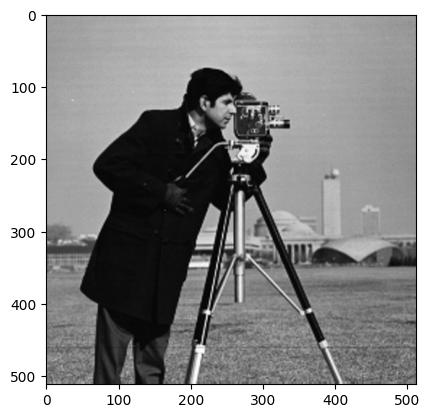

In [6]:
img = plt.imread('cameraman.png')
plt.imshow(img, cmap='gray')

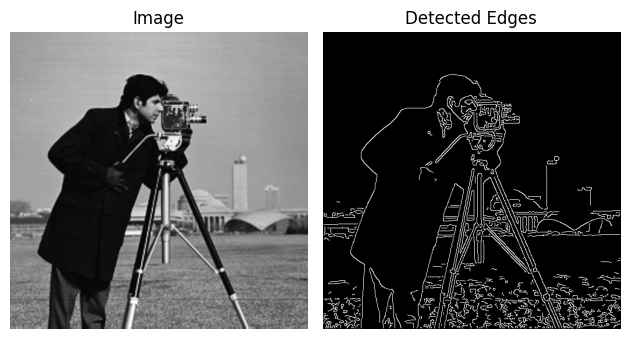

In [7]:
canny = CannyEdgeDetector()

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Image')
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(canny(img), cmap='gray')
plt.title('Detected Edges')
plt.axis(False)

plt.tight_layout()
plt.show()

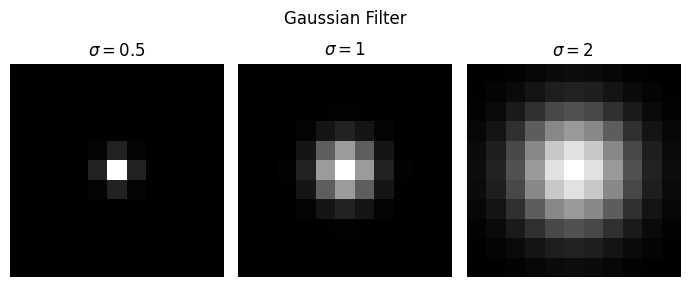

In [8]:
plt.figure(figsize=(7, 3))

plt.subplot(1, 3, 1)
plt.imshow(canny.gaussian_filter(11, 0.5), cmap='gray')
plt.title(r'$\sigma = 0.5$')
plt.axis(False)

plt.subplot(1, 3, 2)
plt.imshow(canny.gaussian_filter(11, 1), cmap='gray')
plt.title(r'$\sigma = 1$')
plt.axis(False)

plt.subplot(1, 3, 3)
plt.imshow(canny.gaussian_filter(11, 2), cmap='gray')
plt.title(r'$\sigma = 2$')
plt.axis(False)

plt.suptitle('Gaussian Filter')

plt.tight_layout()
plt.show()

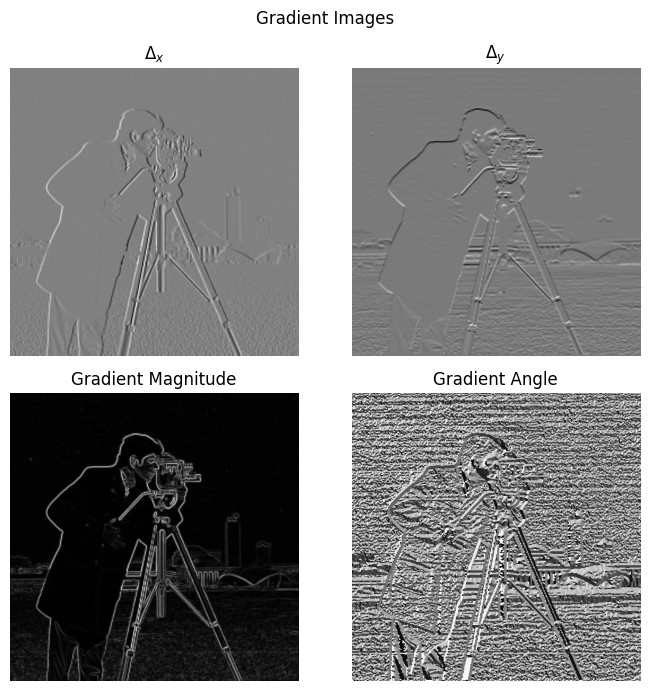

In [9]:
plt.figure(figsize=(7, 7))

plt.subplot(2, 2, 1)
plt.imshow(canny.compute_intensity_gradient_x(img), cmap='gray')
plt.title(r'$\Delta_x$')
plt.axis(False)

plt.subplot(2, 2, 2)
plt.imshow(canny.compute_intensity_gradient_y(img), cmap='gray')
plt.title(r'$\Delta_y$')
plt.axis(False)

mag, ang = canny.compute_intensity_gradient(img)

plt.subplot(2, 2, 3)
plt.imshow(mag, cmap='gray')
plt.title(r'Gradient Magnitude')
plt.axis(False)

plt.subplot(2, 2, 4)
plt.imshow(ang, cmap='gray')
plt.title(r'Gradient Angle')
plt.axis(False)

plt.suptitle('Gradient Images')

plt.tight_layout()
plt.show()